Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning~=2.0
%matplotlib inline

Setup imports

In [2]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.1
Numpy version: 1.24.3
Pytorch version: 2.3.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: d:\Users\hellp\anaconda3\envs\pt_env\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.18.0
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.41.1
mlflow version: 2.13.0
pynrrd version: 1.0.0
clearml version: 1.16.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
# if directory is not None:
#     os.makedirs(directory, exist_ok=True)
# root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = "Lung"
print(root_dir)

Lung


Download dataset

In [4]:
data_dir = "Lung"

Define the LightningModule

In [5]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.validation_step_outputs = []

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files, test_files = data_dicts[:50], data_dicts[50:60], data_dicts[-2:]

        # set deterministic training for reproducibility
        set_determinism(seed=23)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from
                # big image based on pos / neg ratio
                # the image centers of negative samples
                # must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # user can also add other random transforms
                #                 RandAffined(
                #                     keys=['image', 'label'],
                #                     mode=('bilinear', 'nearest'),
                #                     prob=1.0,
                #                     spatial_size=(96, 96, 96),
                #                     rotate_range=(0, 0, np.pi/15),
                #                     scale_range=(0.1, 0.1, 0.1)),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files,
            transform=train_transforms,
            cache_rate=1.0,
            num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files,
            transform=val_transforms,
            cache_rate=1.0,
            num_workers=4,
        )

    #         self.train_ds = monai.data.Dataset(
    #             data=train_files, transform=train_transforms)
    #         self.val_ds = monai.data.Dataset(
    #             data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=2,
            shuffle=True,
            num_workers=4,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}

Run the training

In [7]:
# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=100,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=16,
)

# train
trainer.fit(net)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: Lung\logs\lightning_logs
Loading dataset: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 4.8 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


current epoch: 0 current mean dice: 0.0015
best mean dice: 0.0015 at epoch: 0


Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 0 current mean dice: 0.0004
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 1 current mean dice: 0.0003
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 2 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 3 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 4 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 5 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 6 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 7 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 8 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 9 current mean dice: 0.0002
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 10 current mean dice: 0.0003
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 11 current mean dice: 0.0006
best mean dice: 0.0015 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 12 current mean dice: 0.0019
best mean dice: 0.0019 at epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 13 current mean dice: 0.0012
best mean dice: 0.0019 at epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 14 current mean dice: 0.0017
best mean dice: 0.0019 at epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 15 current mean dice: 0.0012
best mean dice: 0.0019 at epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 16 current mean dice: 0.0017
best mean dice: 0.0019 at epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 17 current mean dice: 0.0016
best mean dice: 0.0019 at epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 18 current mean dice: 0.0039
best mean dice: 0.0039 at epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 19 current mean dice: 0.0043
best mean dice: 0.0043 at epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 20 current mean dice: 0.0078
best mean dice: 0.0078 at epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 21 current mean dice: 0.0093
best mean dice: 0.0093 at epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 22 current mean dice: 0.0085
best mean dice: 0.0093 at epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 23 current mean dice: 0.0321
best mean dice: 0.0321 at epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 24 current mean dice: 0.0385
best mean dice: 0.0385 at epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 25 current mean dice: 0.0419
best mean dice: 0.0419 at epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 26 current mean dice: 0.0874
best mean dice: 0.0874 at epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 27 current mean dice: 0.0477
best mean dice: 0.0874 at epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 28 current mean dice: 0.0879
best mean dice: 0.0879 at epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 29 current mean dice: 0.0425
best mean dice: 0.0879 at epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 30 current mean dice: 0.0846
best mean dice: 0.0879 at epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 31 current mean dice: 0.1218
best mean dice: 0.1218 at epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 32 current mean dice: 0.0419
best mean dice: 0.1218 at epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 33 current mean dice: 0.0679
best mean dice: 0.1218 at epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 34 current mean dice: 0.0745
best mean dice: 0.1218 at epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 35 current mean dice: 0.0533
best mean dice: 0.1218 at epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 36 current mean dice: 0.1352
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 37 current mean dice: 0.1061
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 38 current mean dice: 0.0408
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 39 current mean dice: 0.0886
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 40 current mean dice: 0.0307
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 41 current mean dice: 0.0442
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 42 current mean dice: 0.0356
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 43 current mean dice: 0.0258
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 44 current mean dice: 0.0321
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 45 current mean dice: 0.0122
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 46 current mean dice: 0.0500
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 47 current mean dice: 0.0334
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 48 current mean dice: 0.0641
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 49 current mean dice: 0.1017
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 50 current mean dice: 0.0223
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 51 current mean dice: 0.1144
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 52 current mean dice: 0.0288
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 53 current mean dice: 0.1344
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 54 current mean dice: 0.0604
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 55 current mean dice: 0.1237
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 56 current mean dice: 0.1118
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 57 current mean dice: 0.1129
best mean dice: 0.1352 at epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 58 current mean dice: 0.2066
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 59 current mean dice: 0.0925
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 60 current mean dice: 0.1329
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 61 current mean dice: 0.1068
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 62 current mean dice: 0.1593
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 63 current mean dice: 0.0929
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 64 current mean dice: 0.0956
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 65 current mean dice: 0.1327
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 66 current mean dice: 0.1049
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 67 current mean dice: 0.1216
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 68 current mean dice: 0.1670
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 69 current mean dice: 0.0873
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 70 current mean dice: 0.1183
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 71 current mean dice: 0.1202
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 72 current mean dice: 0.1258
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 73 current mean dice: 0.1626
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 74 current mean dice: 0.1740
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 75 current mean dice: 0.1018
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 76 current mean dice: 0.0942
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 77 current mean dice: 0.1414
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 78 current mean dice: 0.1727
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 79 current mean dice: 0.1206
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 80 current mean dice: 0.1495
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 81 current mean dice: 0.1437
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 82 current mean dice: 0.1672
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 83 current mean dice: 0.1107
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 84 current mean dice: 0.1478
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 85 current mean dice: 0.0902
best mean dice: 0.2066 at epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 86 current mean dice: 0.2167
best mean dice: 0.2167 at epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 87 current mean dice: 0.1979
best mean dice: 0.2167 at epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 88 current mean dice: 0.1277
best mean dice: 0.2167 at epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 89 current mean dice: 0.1785
best mean dice: 0.2167 at epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 90 current mean dice: 0.1787
best mean dice: 0.2167 at epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 91 current mean dice: 0.1580
best mean dice: 0.2167 at epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 92 current mean dice: 0.2450
best mean dice: 0.2450 at epoch: 92


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 93 current mean dice: 0.1709
best mean dice: 0.2450 at epoch: 92


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 94 current mean dice: 0.2545
best mean dice: 0.2545 at epoch: 94


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 95 current mean dice: 0.2285
best mean dice: 0.2545 at epoch: 94


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 96 current mean dice: 0.2111
best mean dice: 0.2545 at epoch: 94


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 97 current mean dice: 0.2088
best mean dice: 0.2545 at epoch: 94


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 98 current mean dice: 0.1882
best mean dice: 0.2545 at epoch: 94


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 99 current mean dice: 0.1611
best mean dice: 0.2545 at epoch: 94


`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
print(f"train completed, best_metric: {net.best_val_dice:.4f} " f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.2545 at epoch 94


Check best model output with the input image and label

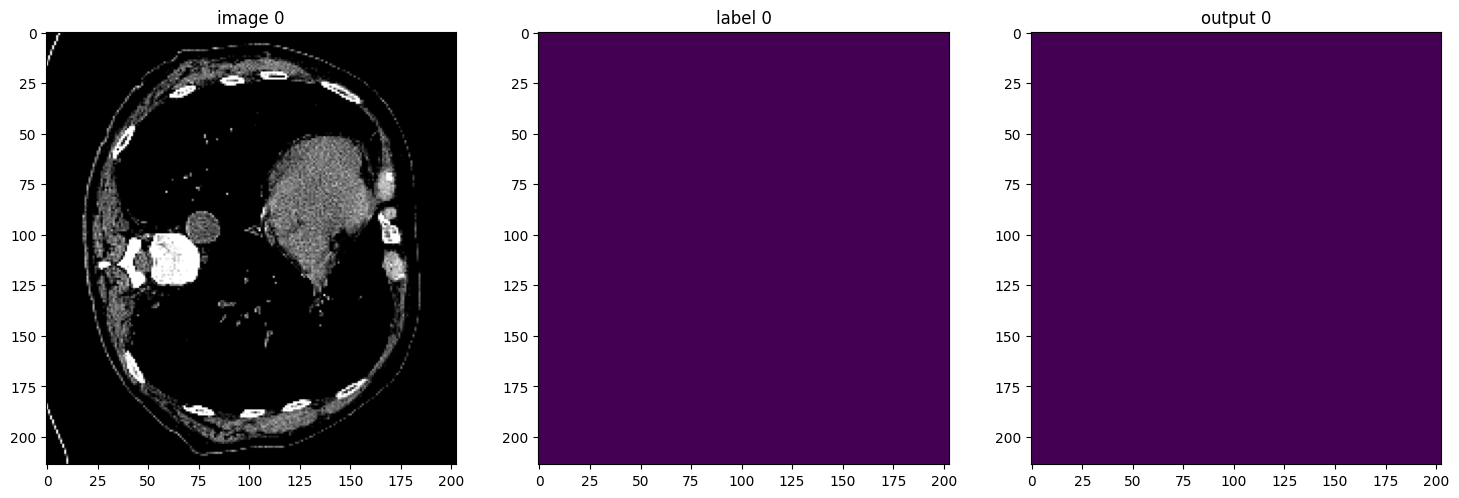

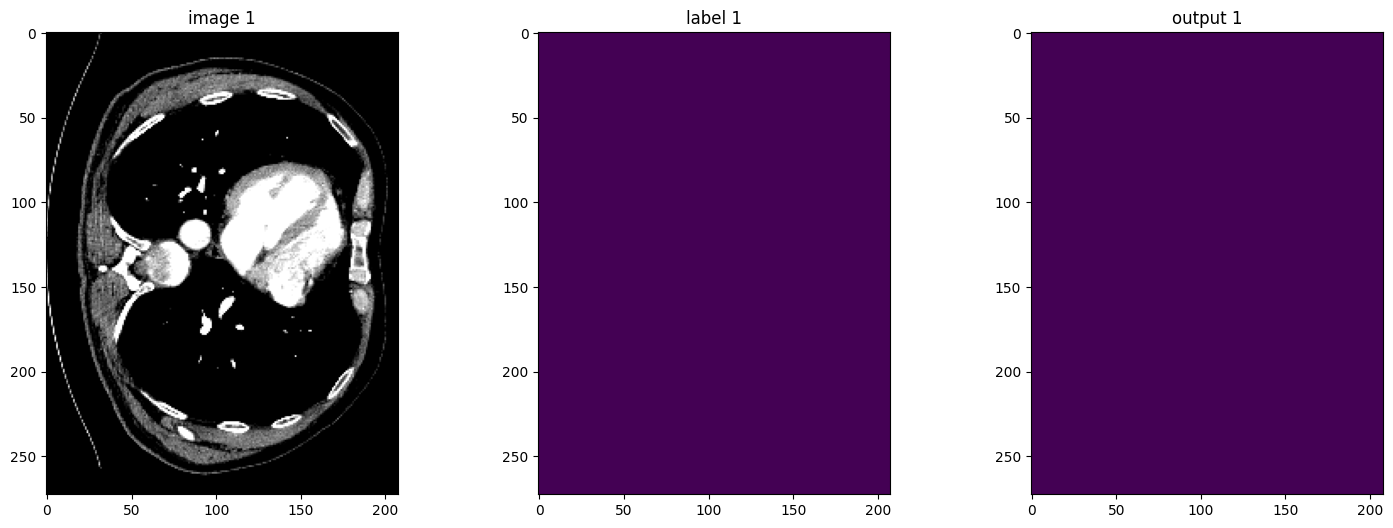

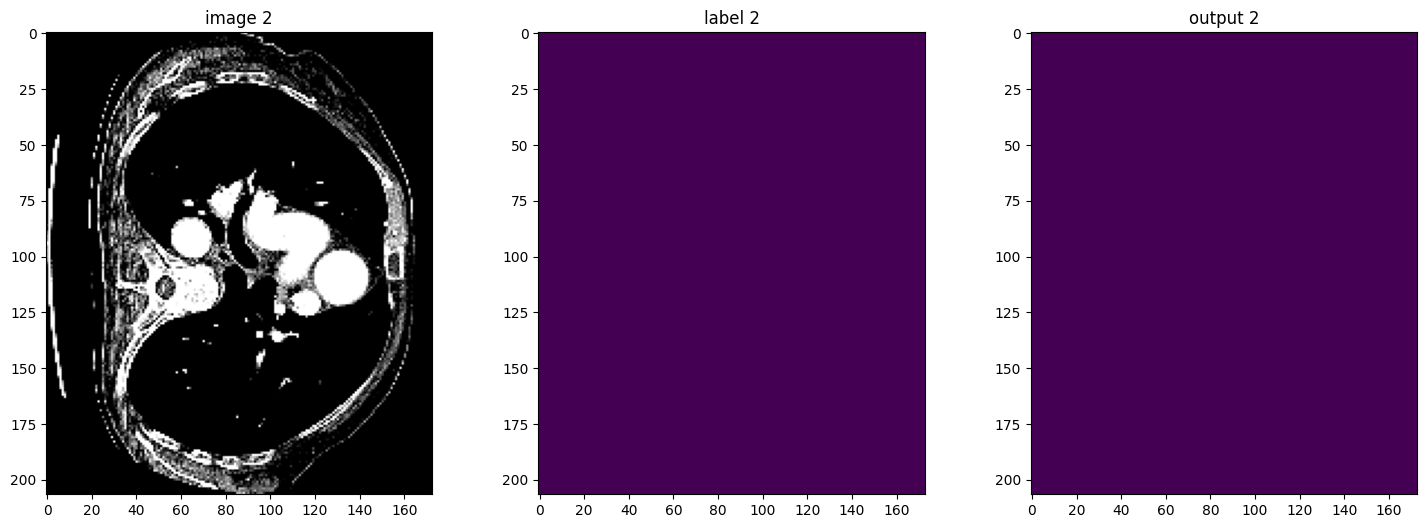

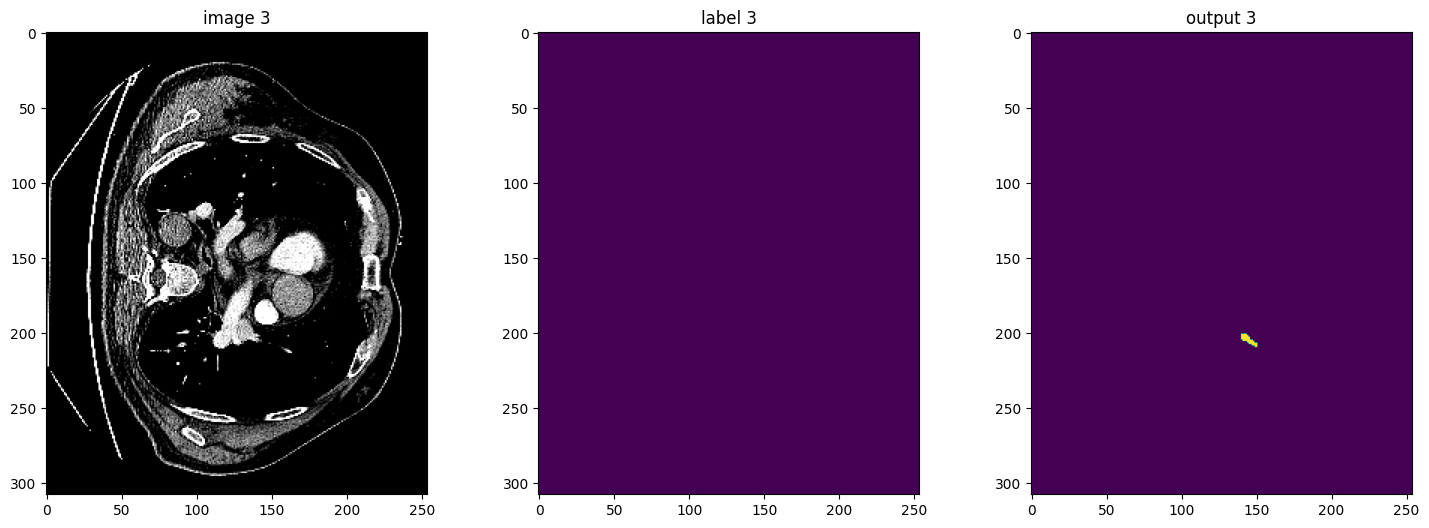

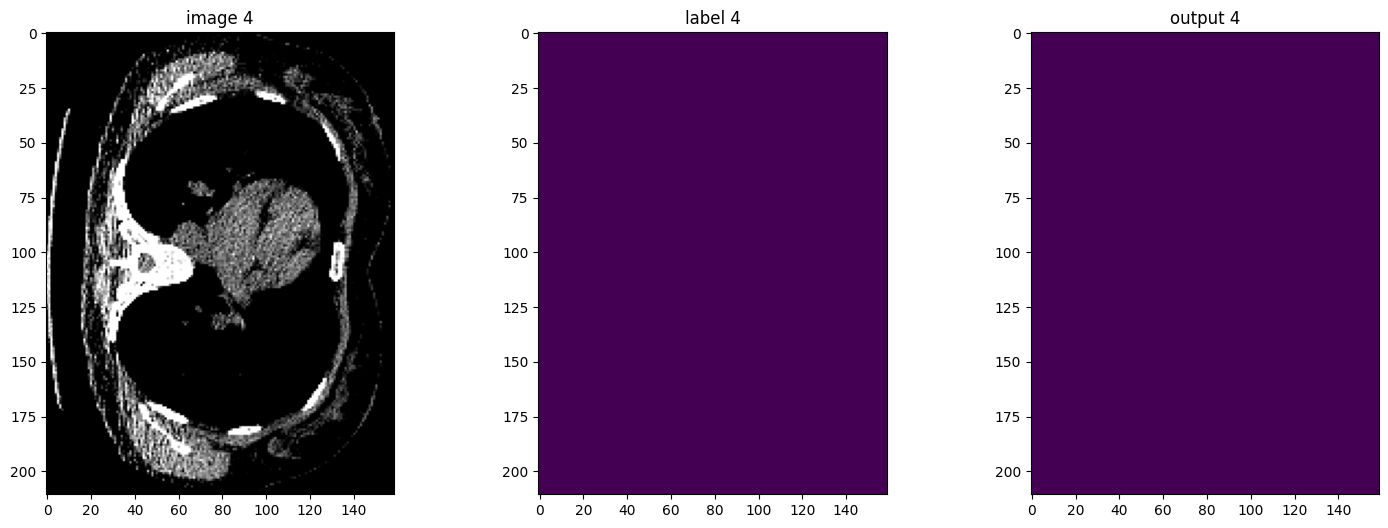

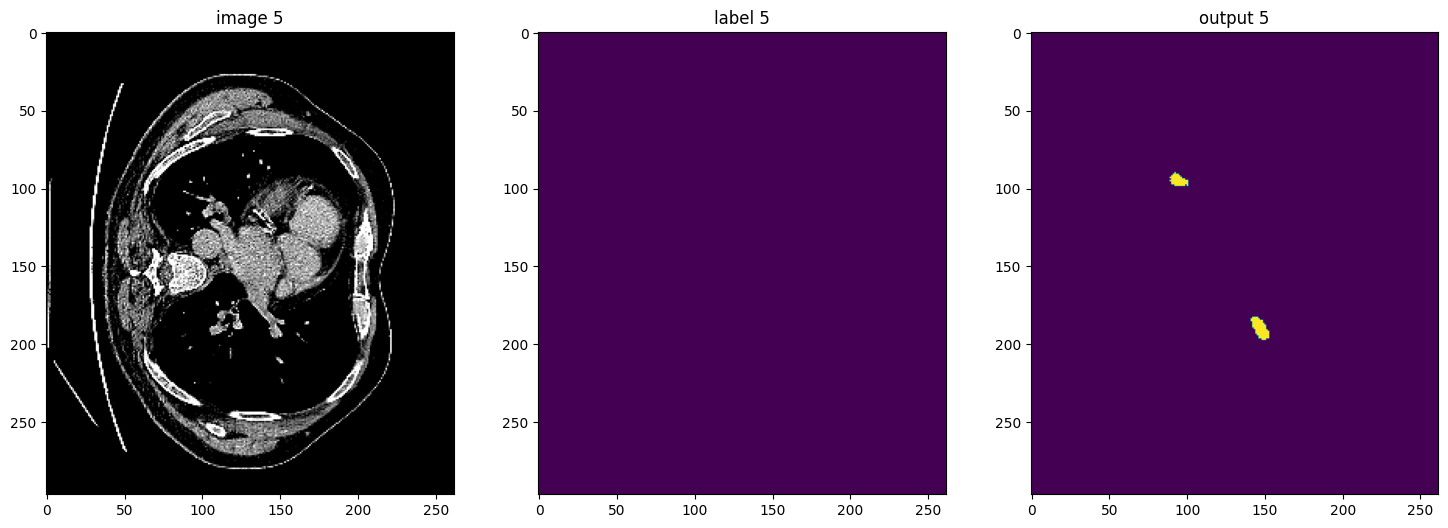

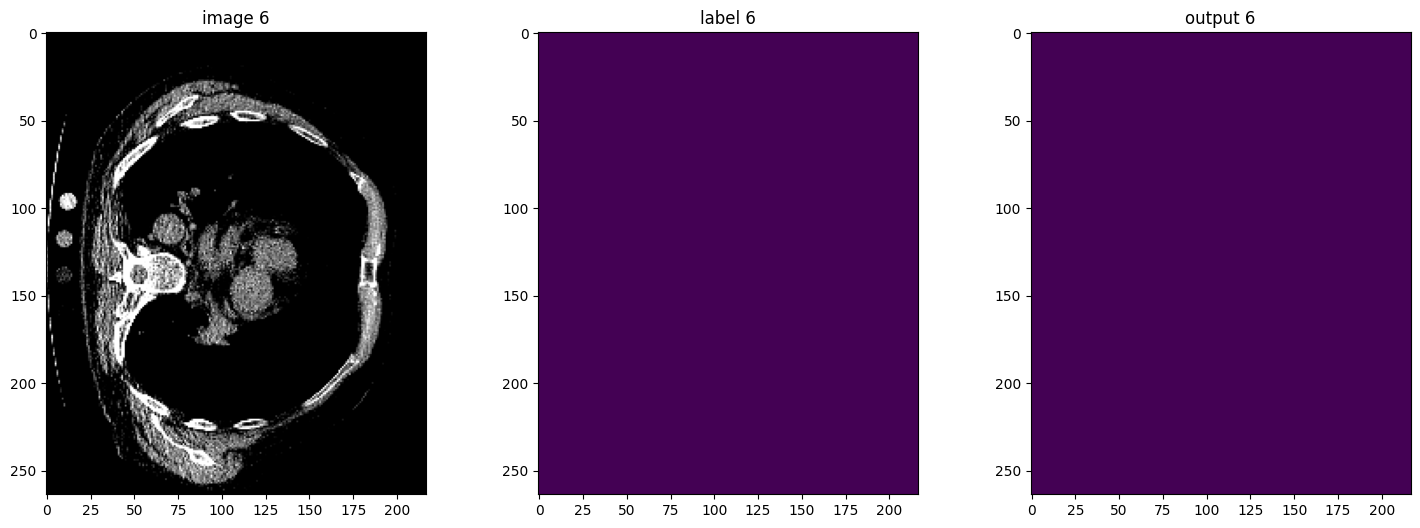

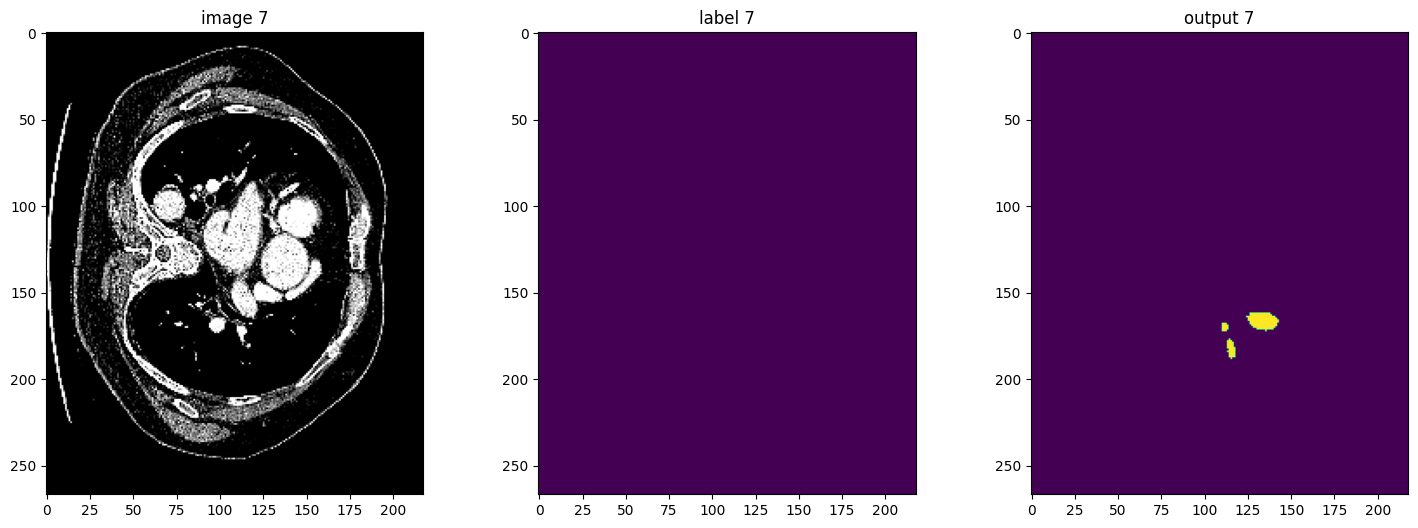

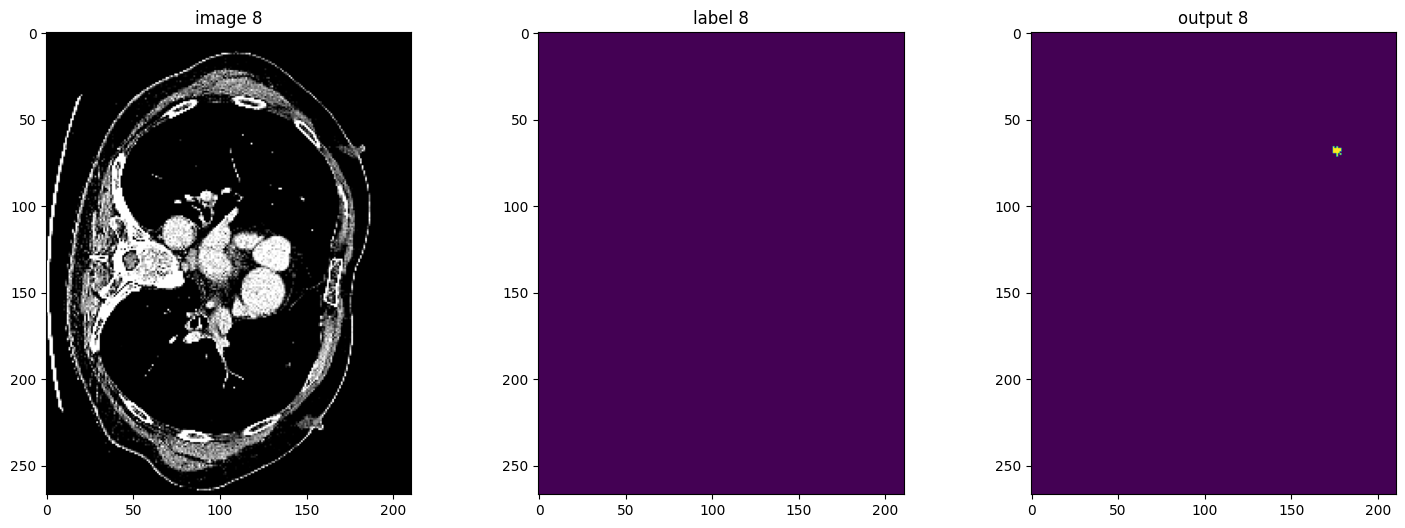

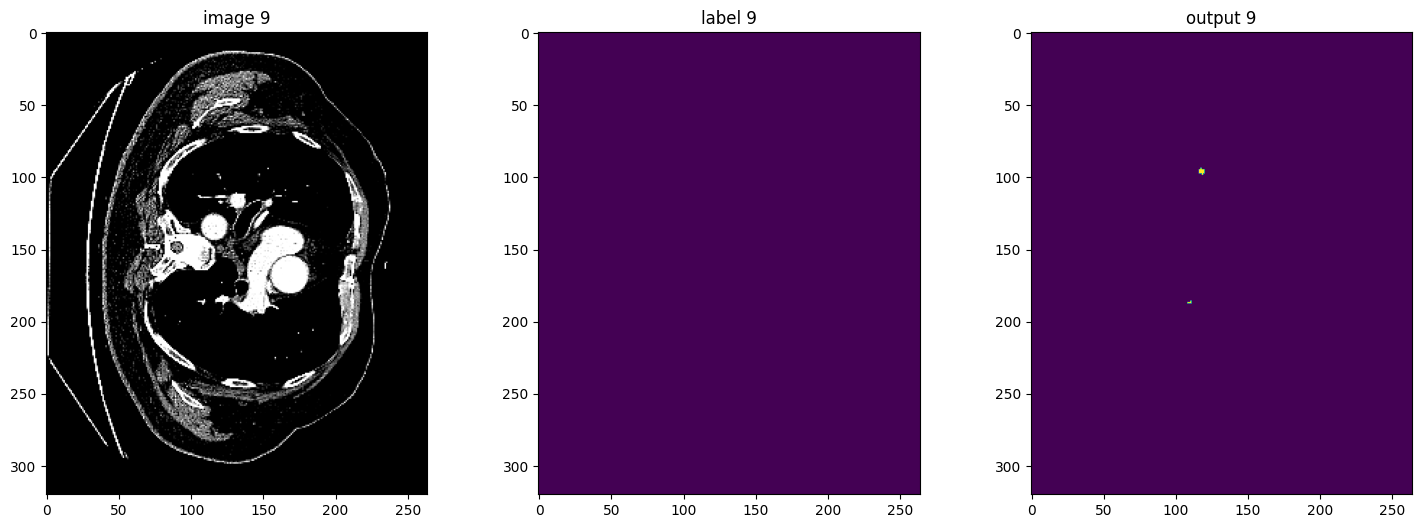

In [9]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, net)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()